In [0]:
# to install kiras
# !pip install -q keras

In [1]:
import numpy as np
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Flatten, Dense, Lambda, Dropout, Activation
from keras.datasets import cifar10
from matplotlib import pyplot as plt
from keras import backend as K
from keras.backend import tf as ktf
from keras.layers.normalization import BatchNormalization
import time

Using TensorFlow backend.


In [0]:
sess = ktf.Session()
K.set_session(sess)

## Load data and prepare it

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

(50000, 32, 32, 3)
[[ 59  62  63]
 [ 43  46  45]
 [ 50  48  43]
 [ 68  54  42]
 [ 98  73  52]
 [119  91  63]
 [139 107  75]
 [145 110  80]
 [149 117  89]
 [149 120  93]
 [131 103  77]
 [125  99  76]
 [142 115  91]
 [144 112  86]
 [137 105  79]
 [129  97  71]
 [137 106  79]
 [134 106  76]
 [124  97  64]
 [139 113  78]
 [139 112  75]
 [133 105  69]
 [136 105  74]
 [139 108  77]
 [152 120  89]
 [163 131 100]
 [168 136 108]
 [159 129 102]
 [158 130 104]
 [158 132 108]
 [152 125 102]
 [148 124 103]]


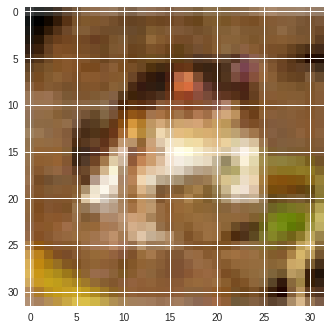

In [15]:
print(X_train.shape)
print(X_train[0][0])
plt.imshow(X_train[0])

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [17]:
print(X_train[0][0])

[[0.23137255 0.24313726 0.24705882]
 [0.16862746 0.18039216 0.1764706 ]
 [0.19607843 0.1882353  0.16862746]
 [0.26666668 0.21176471 0.16470589]
 [0.38431373 0.28627452 0.20392157]
 [0.46666667 0.35686275 0.24705882]
 [0.54509807 0.41960785 0.29411766]
 [0.5686275  0.43137255 0.3137255 ]
 [0.58431375 0.45882353 0.34901962]
 [0.58431375 0.47058824 0.3647059 ]
 [0.5137255  0.40392157 0.3019608 ]
 [0.49019608 0.3882353  0.29803923]
 [0.5568628  0.4509804  0.35686275]
 [0.5647059  0.4392157  0.3372549 ]
 [0.5372549  0.4117647  0.30980393]
 [0.5058824  0.38039216 0.2784314 ]
 [0.5372549  0.41568628 0.30980393]
 [0.5254902  0.41568628 0.29803923]
 [0.4862745  0.38039216 0.2509804 ]
 [0.54509807 0.44313726 0.30588236]
 [0.54509807 0.4392157  0.29411766]
 [0.52156866 0.4117647  0.27058825]
 [0.53333336 0.4117647  0.2901961 ]
 [0.54509807 0.42352942 0.3019608 ]
 [0.59607846 0.47058824 0.34901962]
 [0.6392157  0.5137255  0.39215687]
 [0.65882355 0.53333336 0.42352942]
 [0.62352943 0.5058824  0.4 

In [18]:
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]


In [0]:
# Convert class values to one-hot categorical values
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [20]:
print(Y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### My images' size is 32x32. But to be able to use the pre-trained model weights, we have to enlarge them.


### Let's do it as a layer in the model.

## Load VGG16 model and customize it

In [0]:
image_size = 64
dropout = 0.5
batch_size = 64
epochs = 20

In [0]:
vgg16_model = VGG16(include_top=False, input_shape=(image_size, image_size, 3))

In [22]:
print(vgg16_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [0]:
inp = Input(shape=(None, None, 3))

x = Lambda(lambda image: ktf.image.resize_images(image, (image_size, image_size)))(inp)

# No need to retrain the network.
for layer in vgg16_model.layers:
  layer.trainable = False
  x = layer(x)

# Add the fully-connected layers at the end
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout)(x)
x = Dense(10, activation='softmax', name='predictions')(x)

model = Model(inputs=inp, outputs=x)

In [24]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
__________

In [13]:
optimizer = Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

start_time = time.time()

model.fit(x=X_train, y=Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, verbose=1)

elapsed_time = time.time() - start_time
print ("Training done in {} seconds.".format(elapsed_time))

score = model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: {0}".format(score[1]))

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 76s 2ms/step - loss: 1.6272 - acc: 0.5536 - val_loss: 1.2927 - val_acc: 0.6348
Epoch 2/20
45000/45000 [==============================] - 73s 2ms/step - loss: 1.1779 - acc: 0.6356 - val_loss: 1.0227 - val_acc: 0.6756
Epoch 3/20
45000/45000 [==============================] - 73s 2ms/step - loss: 1.0509 - acc: 0.6636 - val_loss: 0.9643 - val_acc: 0.6968
Epoch 4/20
45000/45000 [==============================] - 73s 2ms/step - loss: 0.9715 - acc: 0.6838 - val_loss: 0.9692 - val_acc: 0.6938
Epoch 5/20
45000/45000 [==============================] - 73s 2ms/step - loss: 0.9115 - acc: 0.6961 - val_loss: 0.9323 - val_acc: 0.6978
Epoch 6/20
45000/45000 [==============================] - 73s 2ms/step - loss: 0.8640 - acc: 0.7102 - val_loss: 0.9296 - val_acc: 0.7098
Epoch 7/20
45000/45000 [==============================] - 73s 2ms/step - loss: 0.8197 - acc: 0.7241 - val_loss: 0.9075 - val_acc:

## Conclusion

Even though I had the computation power this time by using Google Colaboratory and could expriment by trying and shuffling so many hyperparameters and optimizers and extra layers, I still struggled to reach something above 74% accuracy. And each trial of fine-tuning was still clearly reaching a point of overfitting. Which was strange to have a lower accuracy than my own model's accuracy of 82.68% found [here](./cnn_cifar10_v2.ipynb).

But my assumption so far, and from online posts/discussions, is that such model indeed needs more finetuning. Which does not make sense in my case to put more effort in it because  I could work on my own solution anyways to make it better if I want to.